In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn import linear_model 
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action= "ignore")

Bu alıştırmada, modelinizi kullanarak konut fiyatlarını tahmin edeceksiniz. Bu ödevi tamamlamak için, aşağıdaki görevlerin çözümlerini içeren bir Jupyter not defterini link olarak gönderin. Kafanıza takılan konuları mentörünüzle konuşabilir ya da ofis saatinde Slack üzerinden sorabilirsiniz.

1.  Fiyatları verilerini Kaggle'dan indirin.
2. Verilerinizi eğitim ve test kümelerine ayırın.
3. Modelinizi eğitim kümesinden önceki derste olduğu gibi oluşturun. Modelinizin uygunluğunu değerlendirin.
4. Test kümesindeki ev fiyatlarını tahmin edin ve bu derste belirttiğimiz metrikleri kullanarak modelinizin performansını değerlendirin.
5. Modelinizin performansı tatmin edici mi? Açıklayın.
6. Bazı değişkenleri ekleyerek veya çıkararak modelinizi tahmin performansı açısından geliştirmeye çalışın.

In [2]:
ev_fiyatlari = pd.read_csv('data/train.csv', index_col=0)

In [3]:
Y = ev_fiyatlari['SalePrice']

X = ev_fiyatlari[['YearBuilt', 'TotRmsAbvGrd', 'FullBath' , '1stFlrSF', 'TotalBsmtSF',
            'GarageArea', 'GarageCars', 'GrLivArea', 'OverallQual', 'YearRemodAdd']]

In [4]:
len(ev_fiyatlari.columns)

80

In [5]:
ev_fiyatlari.shape

(1460, 80)

In [6]:
#SADECE NUMERIK DATAYI ALMAK ICIN 

ev_fiyatlari_num = ev_fiyatlari._get_numeric_data() 

In [7]:
#bosluk olan satirin hepsini dusurduk
ev_fiyatlari_dropped = ev_fiyatlari.dropna()

In [8]:
ev_fiyatlari_dropped.isnull().sum() 

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
Utilities        0
LotConfig        0
LandSlope        0
Neighborhood     0
Condition1       0
Condition2       0
BldgType         0
HouseStyle       0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
RoofStyle        0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
Foundation       0
BsmtQual         0
                ..
BedroomAbvGr     0
KitchenAbvGr     0
KitchenQual      0
TotRmsAbvGrd     0
Functional       0
Fireplaces       0
FireplaceQu      0
GarageType       0
GarageYrBlt      0
GarageFinish     0
GarageCars       0
GarageArea       0
GarageQual       0
GarageCond       0
PavedDrive       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
PoolQC      

In [9]:
ev_fiyatlari_dropped.shape

(0, 80)

Veri setinden drop ile cikan satirlar tum verilerin kaybina yol acti. 
Bu yuzden ilk veri setinden devam ediyoruz. 


In [10]:
total = ev_fiyatlari.isnull().sum().sort_values(ascending=False)
percent = (ev_fiyatlari.isnull().sum()/ev_fiyatlari.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total>0]

,Total,Percent
PoolQC,1453,0.995
MiscFeature,1406,0.963
Alley,1369,0.938
Fence,1179,0.808
FireplaceQu,690,0.473
LotFrontage,259,0.177
GarageType,81,0.055
GarageCond,81,0.055
GarageFinish,81,0.055
GarageQual,81,0.055


In [11]:
ev_fiyatlari_dropped_na = ev_fiyatlari.copy()

ev_fiyatlari = ev_fiyatlari.drop((missing_data[missing_data['Total'] > 1]).index, axis =1)
ev_fiyatlari = ev_fiyatlari.drop(ev_fiyatlari.loc[ev_fiyatlari['Electrical'].isnull()].index)

In [12]:
ev_fiyatlari_num_na = ev_fiyatlari._get_numeric_data() 

In [13]:
ev_fiyatlari_num_na.shape

(1459, 34)

In [14]:
#abs ile mutlak degerlerin eklenmesi 
corr_list = ev_fiyatlari_num_na.corr().SalePrice.abs().sort_values(ascending = False).index[1:]  #sales price eklenmesin yeniden listeye diye

In [15]:
corr_list

Index(['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF',
       '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd',
       'Fireplaces', 'BsmtFinSF1', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF',
       'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'PoolArea',
       'MSSubClass', 'OverallCond', 'MoSold', '3SsnPorch', 'YrSold',
       'LowQualFinSF', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2'],
      dtype='object')

In [16]:
y_AllValues_afterDropped = ev_fiyatlari_num_na['SalePrice'] 
X_AllValues_afterDropped = ev_fiyatlari_num_na[corr_list]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_AllValues_afterDropped, y_AllValues_afterDropped, test_size = 0.2, random_state = 500)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 1167
Test kümesindeki gözlem sayısı   : 292


In [18]:
X_train = sm.add_constant(X_train)

tum_degiskenli_model = sm.OLS(y_train, X_train).fit()

tum_degiskenli_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     146.0
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:27:45   Log-Likelihood:                -13904.
No. Observations:                1167   AIC:                         2.787e+04
Df Residuals:                    1135   BIC:                         2.803e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.322e+05   1.66e+06      0.380      0.704   -2.63e+06     3.9e+06
OverallQual    1.811e+04   1387.986     13.045      0.000    1.54e+04    2.08e+04
GrLivArea        27.4365      7.054      3.889      0.000      13.596      41.277
GarageCars     1.187e+04   3396.804      3.494      0.000    5202.974    1.85e+04
GarageArea       -4.4580     11.471     -0.389      0.698     -26.965      18.049
TotalBsmtSF      10.3438      3.987      2.594      0.010       2.521      18.167
1stFlrSF         17.0746      7.450      2.292      0.022       2.458      31.692
FullBath       4553.8989   3346.675      1.361      0.174   -2012.465    1.11e+04
TotRmsAbvGrd   5973.4093   1456.743      4.101      0.000    3115.197    8831.622
YearBuilt       345.1552     73.889      4.671      0.000     200.181     490.129
YearRemodAdd    147.2877     78.570      1.875      0.061      -6.871     301.447
Fireplaces     3552.6717   2098.438      1.693      0.091    -564.581    7669.925
BsmtFinSF1        9.7549      2.880      3.387      0.001       4.104      15.406
WoodDeckSF       27.1088      9.434      2.874      0.004       8.600      45.618
2ndFlrSF         20.8706      6.798      3.070      0.002       7.532      34.209
OpenPorchSF     -20.6027     18.009     -1.144      0.253     -55.936      14.731
HalfBath         23.4132   3188.818      0.007      0.994   -6233.227    6280.053
LotArea           0.4059      0.120      3.395      0.001       0.171       0.641
BsmtFullBath   1.108e+04   3023.598      3.665      0.000    5147.982     1.7e+04
BsmtUnfSF         2.2319      2.794      0.799      0.425      -3.249       7.713
BedroomAbvGr  -1.102e+04   2043.861     -5.392      0.000    -1.5e+04   -7010.883
KitchenAbvGr  -1.133e+04   6344.295     -1.786      0.074   -2.38e+04    1113.936
EnclosedPorch     9.3737     19.711      0.476      0.634     -29.300      48.047
ScreenPorch      83.9343     20.994      3.998      0.000      42.743     125.126
PoolArea        -70.5121     28.934     -2.437      0.015    -127.283     -13.741
MSSubClass     -177.2420     30.502     -5.811      0.000    -237.089    -117.395
OverallCond    4233.9558   1177.719      3.595      0.000    1923.205    6544.706
MoSold         -198.8863    406.296     -0.490      0.625    -996.062     598.289
3SsnPorch         2.6431     48.162      0.055      0.956     -91.853      97.139
YrSold         -830.3528    825.541     -1.006      0.315   -2450.111     789.406
LowQualFinSF    -10.5087     18.277     -0.575      0.565     -46.370      25.352
MiscVal          -2.9795      3.486     -0.855      0.393      -9.820       3.861
BsmtHalfBath   5769.4732   4763.171      1.211      0.226   -3576.136    1.51e+04
BsmtFinSF2       -1.6430      5.115     -0.321      0.748     -11.679       8.393
=================================================

In [19]:
#Ayni islemi Sales Pice degerlerini drop ile dusurerek de yapabilirdik. 

y_with_drop = ev_fiyatlari_num_na['SalePrice'] 
X_with_drop = ev_fiyatlari_num_na.drop('SalePrice', axis =1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_with_drop, y_with_drop, test_size = 0.2, random_state = 500)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 1167
Test kümesindeki gözlem sayısı   : 292


In [21]:
X_train = sm.add_constant(X_train)

tum_degiskenli_model = sm.OLS(y_train, X_train).fit()

tum_degiskenli_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     146.0
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:27:45   Log-Likelihood:                -13904.
No. Observations:                1167   AIC:                         2.787e+04
Df Residuals:                    1135   BIC:                         2.803e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.322e+05   1.66e+06      0.380      0.704   -2.63e+06     3.9e+06
MSSubClass     -177.2420     30.502     -5.811      0.000    -237.089    -117.395
LotArea           0.4059      0.120      3.395      0.001       0.171       0.641
OverallQual    1.811e+04   1387.986     13.045      0.000    1.54e+04    2.08e+04
OverallCond    4233.9558   1177.719      3.595      0.000    1923.205    6544.706
YearBuilt       345.1552     73.889      4.671      0.000     200.181     490.129
YearRemodAdd    147.2877     78.570      1.875      0.061      -6.871     301.447
BsmtFinSF1        9.7549      2.880      3.387      0.001       4.104      15.406
BsmtFinSF2       -1.6430      5.115     -0.321      0.748     -11.679       8.393
BsmtUnfSF         2.2319      2.794      0.799      0.425      -3.249       7.713
TotalBsmtSF      10.3438      3.987      2.594      0.010       2.521      18.167
1stFlrSF         17.0746      7.450      2.292      0.022       2.458      31.692
2ndFlrSF         20.8706      6.798      3.070      0.002       7.532      34.209
LowQualFinSF    -10.5087     18.277     -0.575      0.565     -46.370      25.352
GrLivArea        27.4365      7.054      3.889      0.000      13.596      41.277
BsmtFullBath   1.108e+04   3023.598      3.665      0.000    5147.982     1.7e+04
BsmtHalfBath   5769.4732   4763.171      1.211      0.226   -3576.136    1.51e+04
FullBath       4553.8989   3346.675      1.361      0.174   -2012.465    1.11e+04
HalfBath         23.4132   3188.818      0.007      0.994   -6233.227    6280.053
BedroomAbvGr  -1.102e+04   2043.861     -5.392      0.000    -1.5e+04   -7010.883
KitchenAbvGr  -1.133e+04   6344.295     -1.786      0.074   -2.38e+04    1113.936
TotRmsAbvGrd   5973.4093   1456.743      4.101      0.000    3115.197    8831.622
Fireplaces     3552.6717   2098.438      1.693      0.091    -564.581    7669.925
GarageCars     1.187e+04   3396.804      3.494      0.000    5202.974    1.85e+04
GarageArea       -4.4580     11.471     -0.389      0.698     -26.965      18.049
WoodDeckSF       27.1088      9.434      2.874      0.004       8.600      45.618
OpenPorchSF     -20.6027     18.009     -1.144      0.253     -55.936      14.731
EnclosedPorch     9.3737     19.711      0.476      0.634     -29.300      48.047
3SsnPorch         2.6431     48.162      0.055      0.956     -91.853      97.139
ScreenPorch      83.9343     20.994      3.998      0.000      42.743     125.126
PoolArea        -70.5121     28.934     -2.437      0.015    -127.283     -13.741
MiscVal          -2.9795      3.486     -0.855      0.393      -9.820       3.861
MoSold         -198.8863    406.296     -0.490      0.625    -996.062     598.289
YrSold         -830.3528    825.541     -1.006      0.315   -2450.111     789.406
=================================================

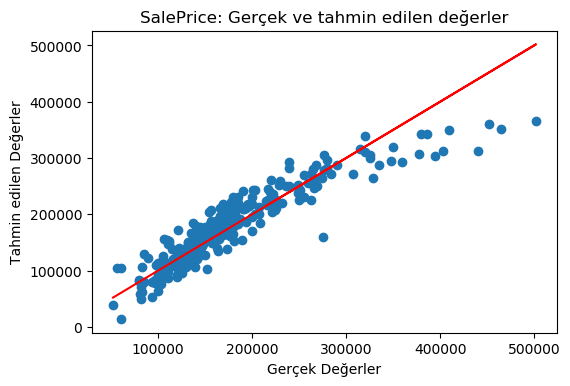

In [22]:
X_test = sm.add_constant(X_test)

y_preds = tum_degiskenli_model.predict(X_test)

plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin edilen Değerler")
plt.title("SalePrice: Gerçek ve tahmin edilen değerler")
plt.show()


Modelimizdeki tahminlerin 300000 fiyatindan sonra tahmin cizgisinden uzaklasarak cok da iyi tahmin edilmedigini goruyoruz. Bunun nedeni kullandigimiz degiskenlerin yetersizliginden kaynaklaniyor olabilir. 

In [23]:
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_preds)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Ortalama Mutlak Hata (MAE)        : 21158.700952408817
Ortalama Kare Hata (MSE)          : 854217461.5092628
Kök Ortalama Kare Hata (RMSE)     : 29226.998845404276
Ortalama Mutlak Yüzde Hata (MAPE) : 12.812839563771394


Bu adimdan sonra X'e atadigimiz tum degiskenler icinden p degeri dusuk olanlar icin yeniden model olusturma islemine geciyoruz.

In [24]:
# bu sekilde liste ve seri olarak kaldi elimizde dataframe gibi tek sutun 

p_degeri = tum_degiskenli_model.pvalues 
anlamli_degerler = list(p_degeri[p_degeri<=0.05].index)

In [25]:
anlamli_degerler

['MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'BsmtFullBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'GarageCars',
 'WoodDeckSF',
 'ScreenPorch',
 'PoolArea']

In [26]:
y_anlamli = ev_fiyatlari_num_na['SalePrice'] 
X_anlamli = ev_fiyatlari_num_na[anlamli_degerler] 

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_anlamli, y_anlamli, test_size = 0.2, random_state = 500)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 1167
Test kümesindeki gözlem sayısı   : 292


In [28]:
X_anlamli = sm.add_constant(X_anlamli)
anlamli_17degiskenli_model = sm.OLS(y_anlamli, X_anlamli).fit()
anlamli_17degiskenli_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     352.4
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:27:46   Log-Likelihood:                -17335.
No. Observations:                1459   AIC:                         3.471e+04
Df Residuals:                    1441   BIC:                         3.480e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -8.963e+05   8.97e+04     -9.990      0.000   -1.07e+06    -7.2e+05
MSSubClass    -182.0266     24.332     -7.481      0.000    -229.757    -134.296
LotArea          0.4279      0.100      4.267      0.000       0.231       0.625
OverallQual   1.946e+04   1131.791     17.194      0.000    1.72e+04    2.17e+04
OverallCond   5357.1062    931.515      5.751      0.000    3529.836    7184.377
YearBuilt      412.2812     45.850      8.992      0.000     322.342     502.221
BsmtFinSF1      11.5740      3.043      3.804      0.000       5.606      17.542
TotalBsmtSF      9.9871      4.165      2.398      0.017       1.817      18.157
1stFlrSF        21.1125     20.070      1.052      0.293     -18.257      60.482
2ndFlrSF        21.1851     19.770      1.072      0.284     -17.596      59.966
GrLivArea       33.3664     19.734      1.691      0.091      -5.345      72.078
BsmtFullBath  7620.7043   2385.445      3.195      0.001    2941.387    1.23e+04
BedroomAbvGr -1.086e+04   1658.845     -6.548      0.000   -1.41e+04   -7608.200
TotRmsAbvGrd  4363.5992   1194.090      3.654      0.000    2021.258    6705.940
GarageCars    1.113e+04   1709.152      6.512      0.000    7777.708    1.45e+04
WoodDeckSF      28.3193      7.939      3.567      0.000      12.745      43.893
ScreenPorch     58.4351     16.861      3.466      0.001      25.360      91.511
PoolArea       -41.6119     23.650     -1.759      0.079     -88.005       4.781
==============================================================================
Omnibus:                      605.149   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106080.417
Skew:                          -0.799   Prob(JB):                         0.00
Kurtosis:                      44.742   Cond. No.                     1.43e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

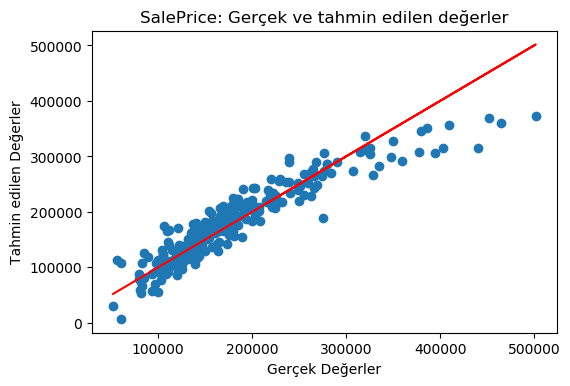

In [29]:
X_test = sm.add_constant(X_test)

y_preds = anlamli_17degiskenli_model.predict(X_test)

plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin edilen Değerler")
plt.title("SalePrice: Gerçek ve tahmin edilen değerler")
plt.show()

In [30]:
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_preds)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Ortalama Mutlak Hata (MAE)        : 20331.79313141801
Ortalama Kare Hata (MSE)          : 778577755.0699136
Kök Ortalama Kare Hata (RMSE)     : 27903.006201302283
Ortalama Mutlak Yüzde Hata (MAPE) : 12.571389418789213


Modelin tahmininde buyuk bir artis olmasa da Rkare degeri %79.9 dan %80.6 ya cikmistir.

In [31]:
X_arttirilmis_anlamli = ev_fiyatlari_num_na[anlamli_degerler[:10]]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_arttirilmis_anlamli, y_anlamli, test_size = 0.2, random_state = 500)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 1167
Test kümesindeki gözlem sayısı   : 292


In [33]:
X_artilirmis_anlamli = sm.add_constant(X_arttirilmis_anlamli)

anlamli_10degiskenli_model = sm.OLS(y_anlamli, X_arttirilmis_anlamli).fit()

anlamli_10degiskenli_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3660.
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:27:46   Log-Likelihood:                -17477.
No. Observations:                1459   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
MSSubClass   -164.6031     26.302     -6.258      0.000    -216.197    -113.010
LotArea         0.4573      0.109      4.189      0.000       0.243       0.671
OverallQual   2.98e+04   1028.915     28.964      0.000    2.78e+04    3.18e+04
OverallCond  -184.7116    905.337     -0.204      0.838   -1960.623    1591.200
YearBuilt     -49.5460      3.969    -12.483      0.000     -57.332     -41.760
BsmtFinSF1     23.0917      2.644      8.734      0.000      17.905      28.278
TotalBsmtSF    11.7468      4.547      2.584      0.010       2.828      20.666
1stFlrSF       74.1776     21.706      3.417      0.001      31.600     116.756
2ndFlrSF       69.7444     21.344      3.268      0.001      27.876     111.613
GrLivArea     -20.1963     20.977     -0.963      0.336     -61.345      20.952
==============================================================================
Omnibus:                      779.504   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100805.877
Skew:                          -1.475   Prob(JB):                         0.00
Kurtosis:                      43.614   Cond. No.                     1.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_preds)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Ortalama Mutlak Hata (MAE)        : 20331.79313141801
Ortalama Kare Hata (MSE)          : 778577755.0699136
Kök Ortalama Kare Hata (RMSE)     : 27903.006201302283
Ortalama Mutlak Yüzde Hata (MAPE) : 12.571389418789213


Tahmin degerlerde anlamli bir fark olmadi ve R kare degeri duserek %78.7'ye geriledi.

10 degiskenli modelimiz sonrasinda birde ilk 5 i alarak model deneyelim

In [35]:
X_daha_arttirilmis_anlamli = ev_fiyatlari_num_na[anlamli_degerler[:5]]

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_daha_arttirilmis_anlamli, y_anlamli, test_size = 0.2, random_state = 500)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape[0]))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape[0]))

Eğitim kümesindeki gözlem sayısı : 1167
Test kümesindeki gözlem sayısı   : 292


In [37]:
X_daha_arttirilmis_anlamli = sm.add_constant(X_daha_arttirilmis_anlamli)

anlamli_5degiskenli_model = sm.OLS(y_anlamli, X_daha_arttirilmis_anlamli).fit()

anlamli_5degiskenli_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     606.1
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:27:46   Log-Likelihood:                -17710.
No. Observations:                1459   AIC:                         3.543e+04
Df Residuals:                    1453   BIC:                         3.546e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -7.731e+05   1.02e+05     -7.549      0.000   -9.74e+05   -5.72e+05
MSSubClass   -158.6258     28.414     -5.583      0.000    -214.362    -102.889
LotArea         1.4012      0.121     11.577      0.000       1.164       1.639
OverallQual  4.034e+04   1070.387     37.685      0.000    3.82e+04    4.24e+04
OverallCond  2339.5139   1168.412      2.002      0.045      47.560    4631.468
YearBuilt     349.6272     52.339      6.680      0.000     246.960     452.294
==============================================================================
Omnibus:                      677.052   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9889.642
Skew:                           1.776   Prob(JB):                         0.00
Kurtosis:                      15.250   Cond. No.                     1.26e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

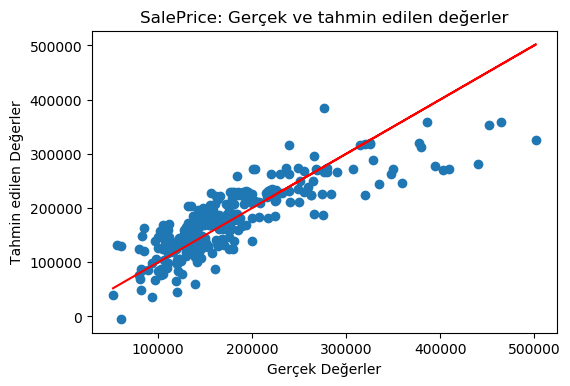

In [38]:
X_test = sm.add_constant(X_test)

y_preds = anlamli_5degiskenli_model.predict(X_test)

plt.figure(dpi = 100)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Gerçek Değerler")
plt.ylabel("Tahmin edilen Değerler")
plt.title("SalePrice: Gerçek ve tahmin edilen değerler")
plt.show()

In [39]:
print("Ortalama Mutlak Hata (MAE)        : {}".format(mean_absolute_error(y_test, y_preds)))
print("Ortalama Kare Hata (MSE)          : {}".format(mse(y_test, y_preds)))
print("Kök Ortalama Kare Hata (RMSE)     : {}".format(rmse(y_test, y_preds)))
print("Ortalama Mutlak Yüzde Hata (MAPE) : {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Ortalama Mutlak Hata (MAE)        : 29655.109991163336
Ortalama Kare Hata (MSE)          : 1644312687.7761793
Kök Ortalama Kare Hata (RMSE)     : 40550.12561973365
Ortalama Mutlak Yüzde Hata (MAPE) : 18.25589746601895


In [40]:
print (anlamli_10degiskenli_model.rsquared)
print (anlamli_17degiskenli_model.rsquared) 
print (tum_degiskenli_model.rsquared)
print(anlamli_5degiskenli_model.rsquared)

0.9619172251239492
0.8061112665753178
0.7994771829911087
0.6759215901690057


Modellerdeki degisken sayilarini azaltmamiz tahmin perfornmansimizi dusurdu. 10 degiskenli modelimiz en iyi performansi gosterdi.

In [41]:
X_arttirilmis_anlamli = ev_fiyatlari_num_na[anlamli_degerler[:10]]

In [42]:
lrm = linear_model.LinearRegression()
lrm.fit(X_arttirilmis_anlamli,y_anlamli)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [43]:
print ('Degiskenler: \n', lrm.coef_)
print ('sabir Deger (Bias): \n ', lrm.intercept_)

Degiskenler: 
 [-1.66245213e+02  5.09602895e-01  2.27604495e+04  5.32278412e+03
  5.10927617e+02  1.90536092e+01  7.44554662e+00  3.53858732e+01
  2.70460864e+01  2.86719591e+01]
sabir Deger (Bias): 
  -1100973.6029661335


In [44]:
Arttirilmis_anlamli_model= sm.add_constant(X_arttirilmis_anlamli)
results = sm.OLS(y_anlamli, X_arttirilmis_anlamli).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     3660.
Date:                Mon, 22 Apr 2019   Prob (F-statistic):               0.00
Time:                        22:27:46   Log-Likelihood:                -17477.
No. Observations:                1459   AIC:                         3.497e+04
Df Residuals:                    1449   BIC:                         3.503e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
MSSubClass   -164.6031     26.302     -6.258      0.000    -216.197    -113.010
LotArea         0.4573      0.109      4.189      0.000       0.243       0.671
OverallQual   2.98e+04   1028.915     28.964      0.000    2.78e+04    3.18e+04
OverallCond  -184.7116    905.337     -0.204      0.838   -1960.623    1591.200
YearBuilt     -49.5460      3.969    -12.483      0.000     -57.332     -41.760
BsmtFinSF1     23.0917      2.644      8.734      0.000      17.905      28.278
TotalBsmtSF    11.7468      4.547      2.584      0.010       2.828      20.666
1stFlrSF       74.1776     21.706      3.417      0.001      31.600     116.756
2ndFlrSF       69.7444     21.344      3.268      0.001      27.876     111.613
GrLivArea     -20.1963     20.977     -0.963      0.336     -61.345      20.952
==============================================================================
Omnibus:                      779.504   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100805.877
Skew:                          -1.475   Prob(JB):                         0.00
Kurtosis:                      43.614   Cond. No.                     1.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""